In [ ]:
#0.98942

In [1]:
import keras as k
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, Conv2D, Flatten, MaxPool2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import model_from_json
import tensorflow as tf

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import itertools

np.random.seed(42)

Using TensorFlow backend.


In [2]:
train = pd.read_csv("inputs/train.csv")
test = pd.read_csv("inputs/test.csv")

In [3]:
#Training data
Y_train = train["label"]
Y_train = k.utils.to_categorical(Y_train, num_classes = 10)
X_train = train.drop(labels = ["label"], axis = 1)
X_train = X_train / 255.0
X_train = X_train.values.reshape(-1, 28, 28, 1)

#Test data
test = test.values.reshape(-1, 28, 28, 1)
test = test / 255.0

#Validation Data
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = .1, random_state = 10)

In [134]:
# load json and create model if we don't want to run again
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


Prediction: 6
Actual: 9


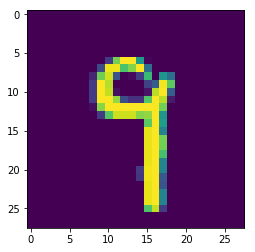

In [139]:
#Display
index = 2 #Good ones, 8, 21, 25
img = X_val[index]
g = plt.imshow(img[:, :, 0])

#Predict
predImg = np.expand_dims(img, axis=0)
pred = model.predict(predImg)
predNum = np.argmax(pred)

#Actual
actual = np.argmax(Y_val[index])
print("Prediction: " + str(predNum))
print("Actual: " + str(actual))

In [4]:
#Model
model = Sequential()
#Architecture
model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'Same', activation = 'relu', input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'Same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(.25))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(.25))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'Same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'Same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(.25))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(.50))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(.25))
model.add(Dense(10, activation = "softmax"))

#Compile
opt = k.optimizers.Adam()
model.compile(opt, loss = 'categorical_crossentropy', metrics = ["accuracy"])

#Train
learning_rate_reduction = ReduceLROnPlateau(monitor='acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
model.fit(X_train, Y_train, batch_size = 64, epochs = 15, callbacks = [learning_rate_reduction])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/15
37800/37800 [==============================] - 185s 5ms/step - loss: 0.4563 - acc: 0.8589
Epoch 2/15
37800/37800 [==============================] - 186s 5ms/step - loss: 0.1194 - acc: 0.9695
Epoch 3/15
37800/37800 [==============================] - 191s 5ms/step - loss: 0.0906 - acc: 0.9760
Epoch 4/15
37800/37800 [==============================] - 191s 5ms/step - loss: 0.0752 - acc: 0.9807
Epoch 5/15
37800/37800 [==============================] - 191s 5ms/step - loss: 0.0608 - acc: 0.9845
Epoch 6/15
37800/37800 [==============================] - 191s 5ms/step - loss: 0.0561 - acc: 0.9851
Epoch 7/15
37800/37800 [==============================] - 191s 5ms/step - loss: 0.0544 - acc: 0.9863
Epoch 8/15
37800/37800 [==============================] - 

In [5]:
model.evaluate(X_val, Y_val)

4200/4200 [==============================] - 10s 2ms/step


[0.04642698385692862, 0.9916666666666667]

In [5]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)

In [123]:
#Save Model
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


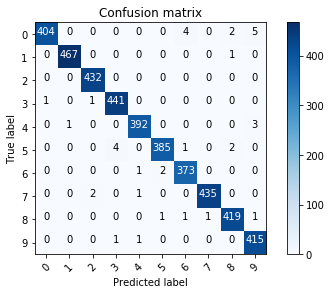

In [126]:
# Look at confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

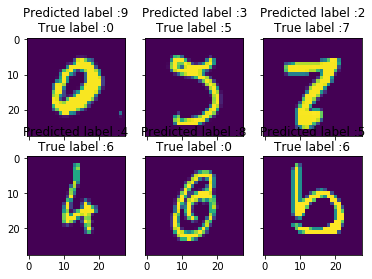

In [127]:
# Display some error results 
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)